# 实例：泰坦尼克号幸存者的预测
泰坦尼克号的沉没是世界上最严重的海难事故之一，今天我们通过分类树模型来预测一下哪些人可能成为幸存者。
[数据集来源](https://www.kaggle.com/c/titanic)。数据集包含两个csv格式文件，data为我们接下来要使用的数据，test为kaggle提供的测试集。
接下来我们就来执行我们的代码。

### 1、导入所需要的库

In [158]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

###  2、导入数据集，探索数据

In [72]:
data = pd.read_csv(r"../../data/Taitanic/data.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
data.info()  # object需要转换为数字，并且缺失值需要补充

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 3、对数据集进行预处理

In [74]:
# 特征选择
# 删除缺失值过多的列，和观察判断来说和预测的y没有关系的列
#  inplace=True：覆盖原表（原数据）
# axis=1：列，axis=0：行
data.drop(['Cabin', 'Name', 'Ticket'], inplace=True, axis=1)  
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [76]:
# 缺失值处理
data['Age'] = data['Age'].fillna(data['Age'].mean())
data = data.dropna()

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 69.5+ KB


In [78]:
# 查看某一特征有多少类
data['Embarked'].unique().tolist()

['S', 'C', 'Q']

In [79]:
# 将分类变量转换为数值型变量
# 将二分类变量转换为数值型变量
# astype能够将一个pandas对象转换为某种类型，和apply(int(x))不同，astype可以将文本类转换为数字，用这个方式可以很便捷地将二分类特征转换为0~1
# data['Sex'] == "male" 返回的是True或者False
data['Sex'] = (data['Sex'] == "male").astype('int')
# 将三分类变量转换为数值型变量（分类之间无关系可以使用该方式）
labels = data['Embarked'].unique().tolist()
data['Embarked'] = data['Embarked'].apply(lambda x: labels.index(x))

In [81]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,0
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,0
3,4,1,1,0,35.0,1,0,53.1000,0
4,5,0,3,1,35.0,0,0,8.0500,0


### 4、提取标签和特征矩阵，分测试集和训练集

In [122]:
x = data.iloc[:, data.columns != "Survived"]
y = data.iloc[:, data.columns == "Survived"]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.3)

In [123]:
Xtrain.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
136,137,1,0,19.000000,0,2,26.2833,0
314,315,2,1,43.000000,1,1,26.2500,0
194,195,1,0,44.000000,0,0,27.7208,1
85,86,3,0,33.000000,3,0,15.8500,0
732,733,2,1,29.699118,0,0,0.0000,0


In [126]:
# 建议修复索引(避免后续代码出现混乱)
# 修正测试集和训练集的索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

### 5、导入模型，粗略跑一下查看结果

In [136]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(Xtrain, Ytrain)
score = clf.score(Xtest, Ytest)
score

0.7602996254681648

In [137]:
# 交叉验证
clf = DecisionTreeClassifier(random_state=25)
score = cross_val_score(clf, x, y, cv=10).mean()
score

0.7469611848825333

### 6、在不同max_depth下观察模型的拟合状况

0.8166624106230849


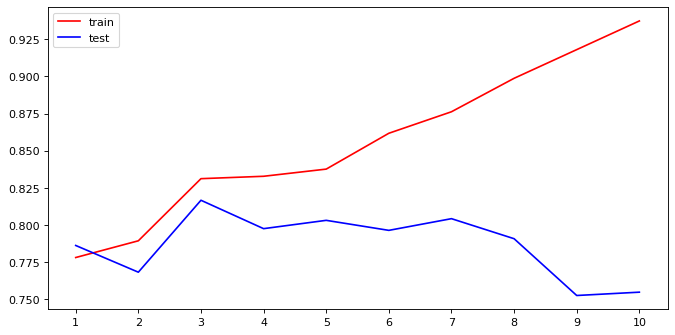

In [156]:
# 调参，max_depth
tr = []  # 训练集分数
te = []  # 测试集分数
for i in range(1, 11):
    # 这里为什么使用“entropy”？因为我们注意到，在最大深度=3的时候，模型拟合不足，
    # 在训练集和测试集上的表现接近，但却都不是非常理想，只能够达到81%左右，所以我们要使用entropy。
    clf = DecisionTreeClassifier(random_state=1,
                                max_depth=i,
                                criterion="entropy",
                                )
    clf.fit(Xtrain, Ytrain)
    score_tr = clf.score(Xtrain, Ytrain)
    score_te = cross_val_score(clf, x, y, cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)

print(max(te))
plt.figure(figsize=(10,5),dpi=80)
# 如果训练集的分数的值远高于测试集的分数，就是过拟合
plt.plot(range(1,11), tr, label="train", c="red")
plt.plot(range(1,11), te, label="test", c="blue")
plt.xticks(range(1,11))
plt.legend()
plt.show()

### 7、 用网格搜索调整参数
    参数取值范围大的时候耗时长

In [160]:
# 一串参数和这些参数对应的我们希望网格搜索搜索的参数的取值范围
gini_thresholds = np.linspace(0,0.5,20)
entropy_thresholds = np.linspace(0,1,20)

parameters = {
    'splitter':('best','random')
     ,'criterion':("gini","entropy")
     ,"max_depth":[*range(1,10)]
     ,'min_samples_leaf':[*range(1,50,5)]
     ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
}

clf = DecisionTreeClassifier(random_state=1)
# GridSearchCV同时包含了fit、score、和交叉验证的功能
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(Xtrain, Ytrain)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_j...
                                                   0.23684210526315788,
                                                   0.2631578947368421,
 

In [161]:
# 从我们输入的参数和参数取值的列表中，返回最佳组合
GS.best_params_  

{'criterion': 'gini',
 'max_depth': 3,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'splitter': 'best'}

In [162]:
# 网格搜索后的模型的评估标准
GS.best_score_

0.8263665594855305

需要注意的是网格搜索中提供的参数都会用到，不会随机选取其中几个网格搜索，所以分数不一定比自己训练出来的分数高